In [1]:
from dotenv import load_dotenv
import os
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import HumanMessage,AIMessage, ToolMessage
from langgraph.graph import add_messages, StateGraph, END
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('Groq') # type: ignore
os.environ["TAVILY_API_KEY"] = os.getenv('Tavily') # type: ignore


In [3]:
class State(TypedDict): 
    messages: Annotated[list, add_messages]


In [4]:

@tool
def web_search(query: str):
    """Search the web for current information and news."""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    formatted_results = []
    if isinstance(result, list): 
        for item in result:
            if isinstance(item, dict): 
                title = item.get('title', 'No Title')
                url = item.get('url', 'No URL')
                content = item.get('content', 'No Content')
                # Truncate content for brevity
                truncated_content = (content[:200] + '...') if len(content) > 200 else content
                formatted_results.append(f"Title: {title}\nURL: {url}\nContent: {truncated_content}\n---")
            else:
                formatted_results.append(f"Unexpected item type: {item}")
        formatted_output = "\n".join(formatted_results)
    else:
        formatted_output = str(result) 

    return f"I searched for: {query}.\n\nResults:\n{formatted_output}"



In [5]:
llm = ChatGroq(model="llama-3.1-8b-instant")
tools = [web_search]
tool_node = ToolNode(tools)
llm_with_tool = llm.bind_tools(tools)

In [6]:

# Chatbot with better prompt
def generate_post(state: State):  
    return { 
        "messages": [llm_with_tool.invoke(state["messages"])] 
    } 

# Routing function - determines next step based on tool calls
def should_use_tool(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if the last message has tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "search"
    else:
        return "get_review_decision"

# Review decision function
def get_review_decision(state: State):   
    post_content = state["messages"][-1].content  
    print("\n==================Current LinkedIn Post:=====================\n") 
    print(post_content) 
    print("\n") 
    decision = input("Post to LinkedIn? (yes/no): ") 
    # Store the decision in state for the router to use
    return {
        "messages": state["messages"] + [HumanMessage(content=f"User decision: {decision}")]
    }

def route_after_review(state: State):
    # Extract the decision from the last message
    last_message = state["messages"][-1].content
    if "User decision: yes" in last_message:
        return "post"
    else:
        return "collect_feedback"

# when you go to the "post" node, the last message in state is "User decision: yes", 
# which is just a string, and you are treating it as your final post content here
# final_post = state["messages"][-1].content  # this is "User decision: yes"
# just returning state will give - InvalidUpdateError: Expected dict, got User decision: yes    
def post(state: State):   
    # Get the actual post content, not the decision string
    for message in reversed(state["messages"]):
        if isinstance(message, AIMessage):
            final_post = message.content
            break
    else:
        final_post = "No AI-generated post found."

    print("\n-----------------Final LinkedIn Post:--------------\n") 
    print(final_post) 
    print("\n✅-----------------Post has been approved and is now live on LinkedIn!-----------------") 
    
    return {
        "messages": state["messages"] + [AIMessage(content=f"Posted: {final_post}")]
    }

 
def collect_feedback(state: State):   
    feedback = input("How can I improve this post? ") 
    return { 
        "messages": [HumanMessage(content=feedback)] 
    } 

In [7]:

workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_post", generate_post)
workflow.add_node("search", tool_node) 
workflow.add_node("get_review_decision", get_review_decision)
workflow.add_node("collect_feedback", collect_feedback)
workflow.add_node("post", post)

# Define transitions
workflow.set_entry_point("generate_post")

# Use conditional edges for routing
workflow.add_conditional_edges(
    "generate_post",
    should_use_tool,
    {
        "search": "search",
        "get_review_decision": "get_review_decision"
    }
)

workflow.add_conditional_edges(
    "get_review_decision",
    route_after_review,
    {
        "post": "post",
        "collect_feedback": "collect_feedback"
    }
)

workflow.add_edge("search", "get_review_decision")
workflow.add_edge("collect_feedback", "generate_post")
workflow.add_edge("post", END)

# Compile graph
app = workflow.compile()

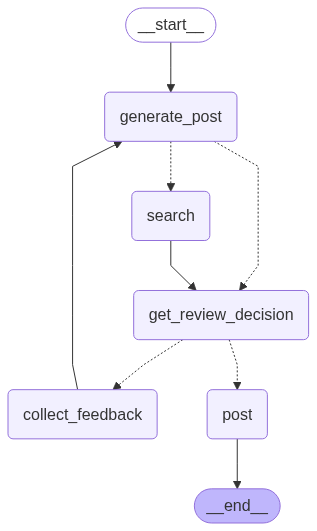

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
response = app.invoke({
    "messages": [HumanMessage(content="Write me a LinkedIn post on AI Agents taking over Jobs, used examples from latest news")]
})


C:\Users\User\AppData\Local\Temp\ipykernel_8652\265425920.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()



==================Current LinkedIn Post:=====================

I searched for: AI Agents taking over Jobs latest news.

Results:
Title: How AI Agents Will Replace Jobs in 2025: What Workers Need to ...
URL: https://medium.com/@daniel.lozovsky/how-ai-agents-will-replace-jobs-in-2025-what-workers-need-to-know-75158b710c87
Content: Sign up

Sign in

Sign up

Sign in

# How AI Agents Will Replace Jobs in 2025: What Workers Need to Know

Daniel Lozovsky

--

Listen

Share

Are you wondering if your job is safe from AI? You’re not ...
---
Title: Is AI changing or threatening to take your job? Tell us about it here
URL: https://www.cnn.com/2025/06/23/tech/ai-impact-on-jobs-callout
Content: Some of Silicon Valley’s top leaders have warned in recent weeks that artificial intelligence is coming for people’s jobs — and fast.

Anthropic CEO Dario Amodei warned last month that AI could cause ...
---
Title: Companies That Have Replaced Workers with AI in 2024 & 2025
URL: https://tech.co/news/compan

In [17]:
print(response["messages"][-3].content)

I searched for: Persistent Systems AI investment.

Results:
Title: Persistent Systems Banks On AI Revolution To Drive Growth
URL: https://www.ndtvprofit.com/quarterly-earnings/persistent-systems-banks-on-ai-revolution-to-drive-growth
Content: “There’s a much bigger pivot happening on the technology side, and that is the AI pivot at a broader level,” he explained.

The top executive said that Persistent Systems’ investments in AI over the l...
---
Title: Persistent Advances Data Privacy and AI-Driven Business ...
URL: https://www.prnewswire.com/news-releases/persistent-advances-data-privacy-and-ai-driven-business-transformation-with-the-acquisition-of-arrka-302262206.html
Content: PUNE, India, Sept. 30, 2024 /PRNewswire/ -- Persistent Systems (BSE: 533179) (NSE: PERSISTENT), a global pioneer in Digital Engineering and Enterprise Modernization, today announced the intent to acqu...
---
Title: AI for Wealth Management System | Digital Investment Services
URL: https://www.persistent.com/in

In [20]:
print(response["messages"][6].content)

I searched for: Indian IT company investing in AI.

Results:
Title: Best AI Stocks in India: Top Companies to Invest in for 2025
URL: https://appreciatewealth.com/blog/best-artificial-intelligence-stocks-in-india
Content: ### Persistent Systems

Persistent Systems is a well-known Indian IT company that specialises in software product development and digital engineering. It has a strong pedigree in building software for...
---
Title: Indian Companies Are Investing In AI For The Long Term, Intend To ...
URL: https://in.newsroom.ibm.com/2025-02-12-Indian-Companies-Are-Investing-In-AI-For-The-Long-Term-IBM-Study
Content: # Announcements

# Indian Companies are Investing in AI for the Long Term, Intend to Use Open-Source Tools to Drive ROI and Innovation: IBM Study

Bengaluru, India, February 12, 2025 -- New research c...
---
Title: Top Artificial Intelligence Stocks In India to Watch In 2025 - Grip Invest
URL: https://www.gripinvest.in/blog/artificial-intelligence-stocks-in-india
Content: 